# Experiment 1

In [ ]:
from itertools import product
import json
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle, Arrow, Circle
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

from vgc_project.r import create_R_model_interface, ImmutableDataFrame
from vgc_project.parameter_fit import create_fit_vgc_model_to_trials, Trial

joblib_cache_location = "./_analysiscache"
rmods = create_R_model_interface(joblib_cache_location=joblib_cache_location)
fit_vgc_model_to_trials = create_fit_vgc_model_to_trials(joblib_cache_location=joblib_cache_location)

import analysisutils
from analysisutils import predictor_names, short_predictor_names
from prep_data import \
    mazes,\
    model_preds,\
    get_exp1_at

exp1_at = get_exp1_at()

R[write to console]: Loading required package: Matrix



# Static VGC

## $\chi^2$ test

In [2]:
exp1_means = exp1_at.groupby(['grid', 'obstacle'])[["attention_N", "static_vgc_weight"]].mean().reset_index()
exp1_contab = pd.crosstab(exp1_means["attention_N"] >= .5, exp1_means["static_vgc_weight"] >= .5)
chi2, pval, dof, exp = stats.chi2_contingency(exp1_contab, correction=False)
chi2_effectsize_w = np.sqrt(chi2/len(exp1_means))
pval = analysisutils.pval_to_string(pval)
exp1_chi2_res = f"$\chi^2({dof}, N={len(exp1_means)})={chi2:.2f}$, $p {pval}$, effect size $w = {chi2_effectsize_w:.2f}$"

with open("./inputs/exp1_chi2_res_svgc.tex", "w") as f:
    f.write(exp1_chi2_res)
print(exp1_chi2_res)

$\chi^2(1, N=84)=23.03$, $p = 1.6 \times 10^{-6}$, effect size $w = 0.52$


## HGLM with VGC

In [3]:
exp1_at_im = ImmutableDataFrame(exp1_at)

In [4]:
exp1_vgc_single_summary = analysisutils.single_predictor_analysis(
    name='Exp. 1 VGC attention model',
    data=exp1_at_im,
    dv='attention_N',
    model_func='lmer',
    random_effects='(1 | sessionId) + (1 | grid)',
    predictor='static_vgc_weight_Z',
    rmods=rmods,
    coeff_digits=3,
    normalized_predictor=True
)
with open("./inputs/exp1_vgc_single_summary_svgc.tex", 'w') as file:
    file.write(exp1_vgc_single_summary.summary)
print(exp1_vgc_single_summary.summary)

$\chi^2(1) = 2297.21, p  < 1.0 \times 10^{-16}$; $\beta = 0.133$, S.E. $= 0.003$


## Exp 1 Figures

In [5]:
expmod_means = exp1_at.groupby(['grid', 'obstacle'])[['attention_N', "static_vgc_weight"]].\
    mean().reset_index()

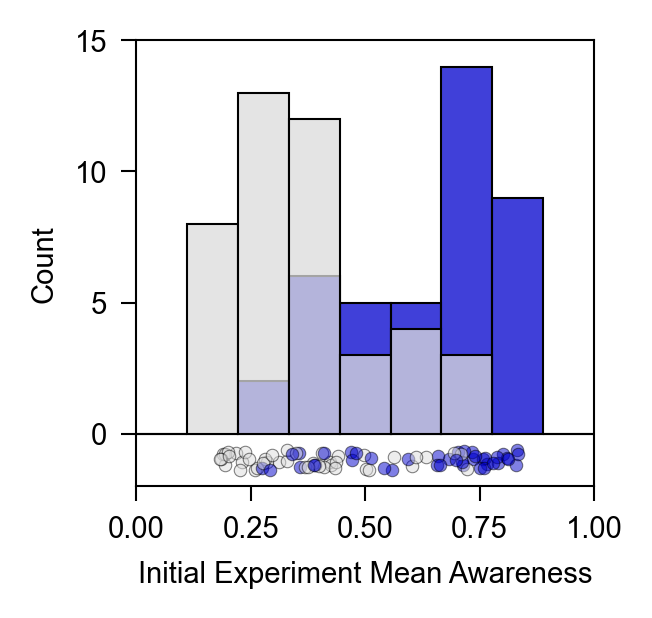

In [6]:
# create figure
fig_width_mm = 50
fig_height_mm = 50
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
fig, ax = plt.subplots(
    1, 1, 
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
for spine in ['top','bottom','left','right']:
    ax.spines[spine].set_linewidth(.5)
    
    
bins = np.linspace(0, 1, 10)
sns.histplot(
    expmod_means[expmod_means['static_vgc_weight'] >= .5]['attention_N'],
    ax=ax, kde=False, bins=bins, color='mediumblue', linewidth=.5
)
sns.histplot(
    expmod_means[expmod_means['static_vgc_weight'] < .5]['attention_N'],
    ax=ax, kde=False, bins=bins, color='gainsboro', linewidth=.5
)

for _, row in expmod_means.iterrows():
    ax.plot(
        # [row['attention_N'], row['attention_N']], [-2, -.1],
        [row['attention_N'], ], [-1+(.5 - np.random.random())*.8],
        marker='.',
        alpha=.5,
        markersize=6,
        # markercolor='mediumblue' if row['vgc_weight'] >= .5 else 'gainsboro'
        color='mediumblue' if row['static_vgc_weight'] >= .5 else 'gainsboro',
        markeredgewidth=.25,
        markeredgecolor='k'
    )


ax.tick_params(axis='both', width=.5)
ax.set(**dict(
    xticks=[0, .25, .5, .75, 1],
    xlim=(0, 1),
    ylim=(-2, 15),
    yticks=[0, 5, 10, 15],
))
ax.set_xlabel('Initial Experiment Mean Awareness', fontsize=7, fontfamily = "Arial")
ax.set_ylabel('Count', fontsize=7, fontfamily = "Arial")
plt.yticks(fontname = "Arial", fontsize=7)
plt.xticks(fontname = "Arial", fontsize=7)
fig.savefig("results/exp1_hist_svgc.pdf")
# fig.set_dpi(150)

In [7]:
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue
    
def plot_grid_obstacle_values(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    ax_pad=.25/4,
    color_mix_alpha=12,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    for side in ['top','right','bottom','left']:
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "0123456789":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = 'white'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .5, y + .5,
                markeredgecolor='blue',
                marker='o',
                markersize=2.5,
                markeredgewidth=.5,
                fillstyle='none'
            )
        elif loc_feature == "G":
            goal = Rectangle(
                (x + .25, y + .25),
                .5, .5,
                color='green',
                lw=0
            )
            ax.add_patch(goal)

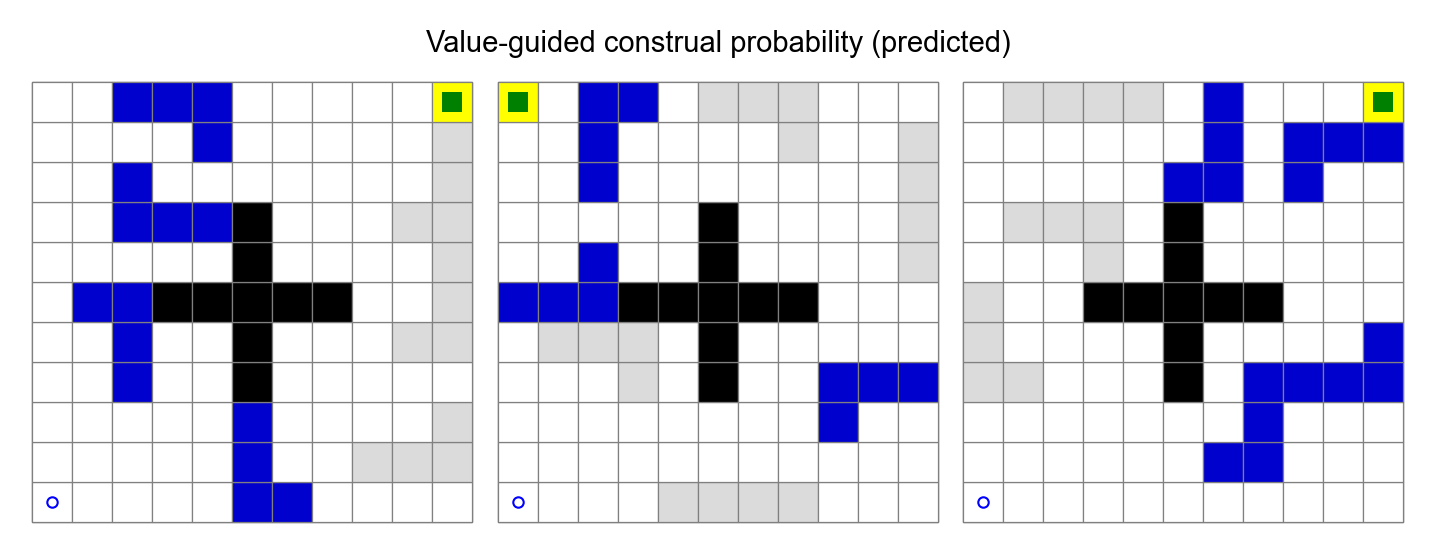

In [8]:
# model predictions
# create figure
fig_width_mm = 120
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [11, 2, 5]
to_plot = expmod_means[expmod_means["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(to_plot['grid'].unique())
ncols = 3
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = expmod_means.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_values(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "yellow"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.85)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("results/exp1_3maze_preds_svgc.pdf")

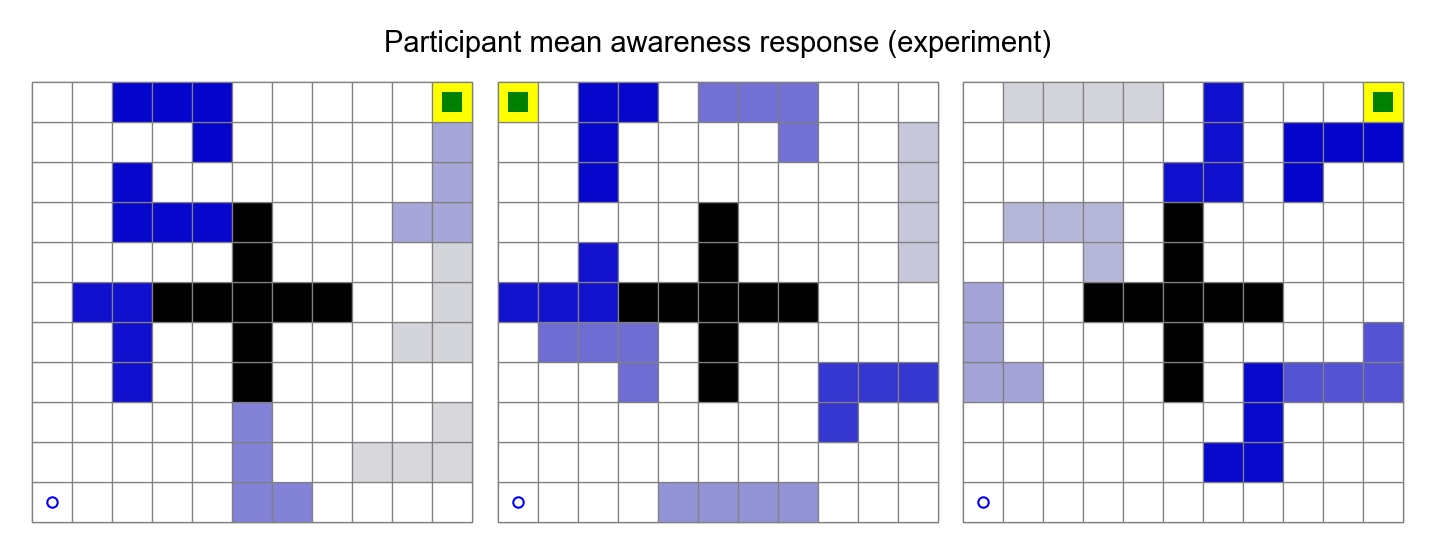

In [9]:
# responses
# create figure
fig_width_mm = 120
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [11, 2, 5]
to_plot = expmod_means[expmod_means["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(to_plot['grid'].unique())
ncols = 3
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'attention_N'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = expmod_means.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_values(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "yellow"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Participant mean awareness response (experiment)", font="Arial", y=.85)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("results/exp1_3maze_data_svgc.pdf")

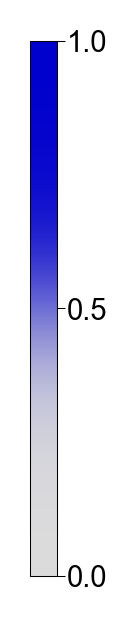

In [10]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import cm

N=256
vmin=0
vmax=1
ticks=[0, .5, 1]

fig_width_mm = 20
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, ax = plt.subplots(
    1, 1,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)

vals = np.linspace(0, 1, N)[:,None]
vals = color_mix(vals)
newcmp = ListedColormap(vals)
norm = Normalize(vmin=vmin, vmax=vmax)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp), ticks=ticks)
cb.ax.tick_params(axis = 'both', which = 'major', width=.25, length=2, pad=.5)
cb.outline.set_linewidth(.25)
cb.minorticks_off()
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("Arial")
    l.set_fontsize(7)
ax.remove()
fig.savefig("results/exp1_colorbar_svgc.pdf")

# Dynamic VGC

## HGLM with VGC

In [11]:
exp1_at_im = ImmutableDataFrame(exp1_at)

In [12]:
exp1_vgc_single_summary = analysisutils.single_predictor_analysis(
    name='Exp. 1 VGC attention model',
    data=exp1_at_im,
    dv='attention_N',
    model_func='lmer',
    random_effects='(1 | sessionId) + (1 | grid)',
    predictor='dynamic_vgc_weight_Z',
    rmods=rmods,
    coeff_digits=3,
    normalized_predictor=True
)
with open("./inputs/exp1_vgc_single_summary_dvgc.tex", 'w') as file:
    file.write(exp1_vgc_single_summary.summary)
print(exp1_vgc_single_summary.summary)

$\chi^2(1) = 2887.89, p  < 1.0 \times 10^{-16}$; $\beta = 0.159$, S.E. $= 0.003$


/Users/markho/Dropbox/Cog-Sci-Research/Projects-active/Frames/vgc_project/vgc_project/r.py:56: UserWarning: Persisting input arguments took 0.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  cache[key] = func(*args, **kw)


## Figures

In [13]:
expmod_means = exp1_at.groupby(['grid', 'obstacle'])[['attention_N', "static_vgc_weight", "dynamic_vgc_weight"]].\
    mean().reset_index()

Text(0.45, 0.6, '$R^2=0.50$  ')

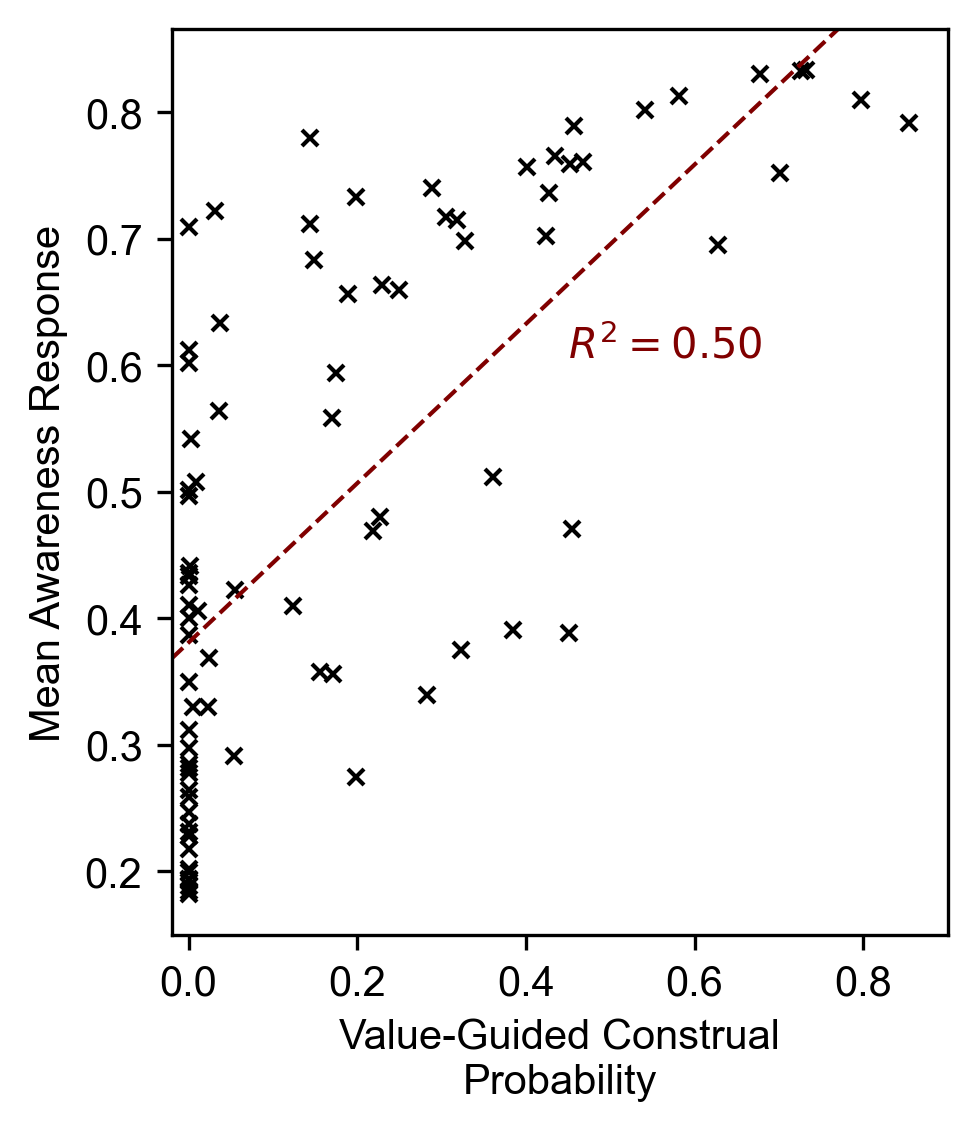

In [14]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.patches import Rectangle
import matplotlib

matplotlib.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
attention_cutoff = .1
attended = expmod_means["dynamic_vgc_weight"] >= attention_cutoff

matplotlib.rcParams['hatch.linewidth'] = 1.5  # previous svg hatch linewidth
matplotlib.rcParams['font.size'] = 10

ax.plot(
    expmod_means["dynamic_vgc_weight"],
    expmod_means["attention_N"],
    linestyle="none",
    marker="x",
    markeredgecolor="k",
    mew=1,
    markersize=4,
)
# ax.plot(
#     expmod_means["dynamic_vgc_weight"][~attended],
#     expmod_means["attention_N"][~attended],
#     linestyle="none",
#     marker="x",
#     markeredgecolor="lightgrey",
#     mew=1,
#     markersize=4,
# )
ax.set_xlim(-0.02, .9)
ax.set_aspect(1.5)

linreg = stats.linregress(expmod_means['dynamic_vgc_weight'], expmod_means['attention_N'])
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(
    xlim,
    linreg.intercept + linreg.slope*np.array(xlim),
    linestyle='--',
    color='maroon',
    linewidth=1
)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
# ax.add_patch(Rectangle((xlim[0], ylim[0]), -xlim[0]+attention_cutoff, ylim[1]-ylim[0], color='gainsboro', zorder=-5))
# ax.add_patch(Rectangle((xlim[0], ylim[0]), -xlim[0]+attention_cutoff+.1, ylim[1]-ylim[0], hatch="/"*5, ec='w', lw=0, fill=False, zorder=-4))
# ax.add_patch(Rectangle((attention_cutoff, ylim[0]), xlim[1], ylim[1]-ylim[0], color='lightcyan', zorder=-5))
# ax.plot(
#     [.02, .02],
#     ylim,
#     linestyle='--',
#     linewidth=.5
# )
ax.set_ylabel("Mean Awareness Response").set_rotation(90)
ax.set_xlabel("Value-Guided Construal\nProbability")
ax.text(.45, .6, f"$R^2={linreg.rvalue**2:.2f}$  ", ha='left', va="bottom", color='maroon')

<AxesSubplot:xlabel='dynamic_vgc_weight', ylabel='attention_N'>

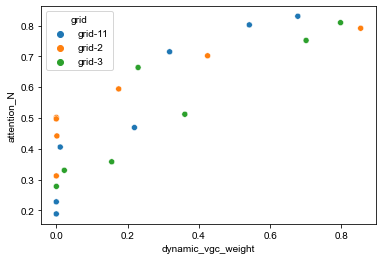

In [15]:
sns.scatterplot(
    data=expmod_means[expmod_means['grid'].isin([f'grid-{g}' for g in [2, 3, 11]])],
    # data=expmod_means,
    x="dynamic_vgc_weight",
    y="attention_N",
    hue="grid"
)

In [16]:
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))
whitesmoke = np.array(to_rgb('whitesmoke'))
white = np.array(to_rgb('white'))

def color_mix(
    v,
    alpha=12
):
    # w = 1/(1 + np.exp(-alpha*(v-.5)))
    w = v
    return (1-w)*white + w*mediumblue
    
def plot_grid_obstacle_values(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    hatch_cutoff=-1,
    ax_pad=.25/4,
    color_mix_alpha=7,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    for side in ['top','right','bottom','left']:
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='none',
        fill=False,
        ec='k', 
        lw=grid_lineweight,
        zorder=2
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        hatch_obstacle = False
        if loc_feature in "0123456789":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
            if obs_value <= hatch_cutoff:
                hatch_obstacle = True
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = 'white'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight,
            # hatch="" if not hatch_obstacle else "/"*15,
            # linestyle="-" if not hatch_obstacle else "--"
            zorder=-2
        )
        ax.add_patch(square)
        if hatch_obstacle:
            square = Rectangle(
                (x, y),
                1, 1,
                color='none',
                ec='gainsboro', 
                lw=0,
                hatch="/"*6,
                zorder=-1
            )
            ax.add_patch(square)
            
        
        if loc_feature == "S":
            ax.plot(
                x + .5, y + .5,
                markeredgecolor='blue',
                marker='o',
                markersize=2.5,
                markeredgewidth=.5,
                fillstyle='none'
            )
        elif loc_feature == "G":
            goal = Rectangle(
                (x + .25, y + .25),
                .5, .5,
                color='green',
                lw=0
            )
            ax.add_patch(goal)

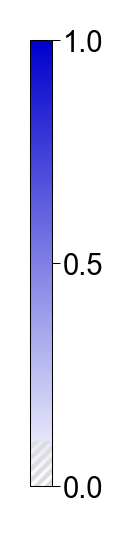

In [17]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import cm

matplotlib.rcParams['hatch.linewidth'] = 1  # previous svg hatch linewidth

N=256
vmin=0
vmax=1
ticks=[0, .5, 1]

fig_width_mm = 20
fig_height_mm = 50
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, ax = plt.subplots(
    1, 1,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)

vals = np.linspace(0, 1, N)[:,None]
vals = color_mix(vals)
newcmp = ListedColormap(vals)
norm = Normalize(vmin=vmin, vmax=vmax)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp), ticks=ticks)
cb.ax.tick_params(axis = 'both', which = 'major', width=.25, length=2, pad=.5)
cb.outline.set_linewidth(.25)
cb.minorticks_off()
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("Arial")
    l.set_fontsize(7)
ax.remove()
cb.ax.add_patch(Rectangle((0, 0), 1, attention_cutoff, fill=False, ec='gainsboro', lw=0, hatch='/'*9))
# fig.savefig("results/exp1_colorbar1_dvgc.pdf")

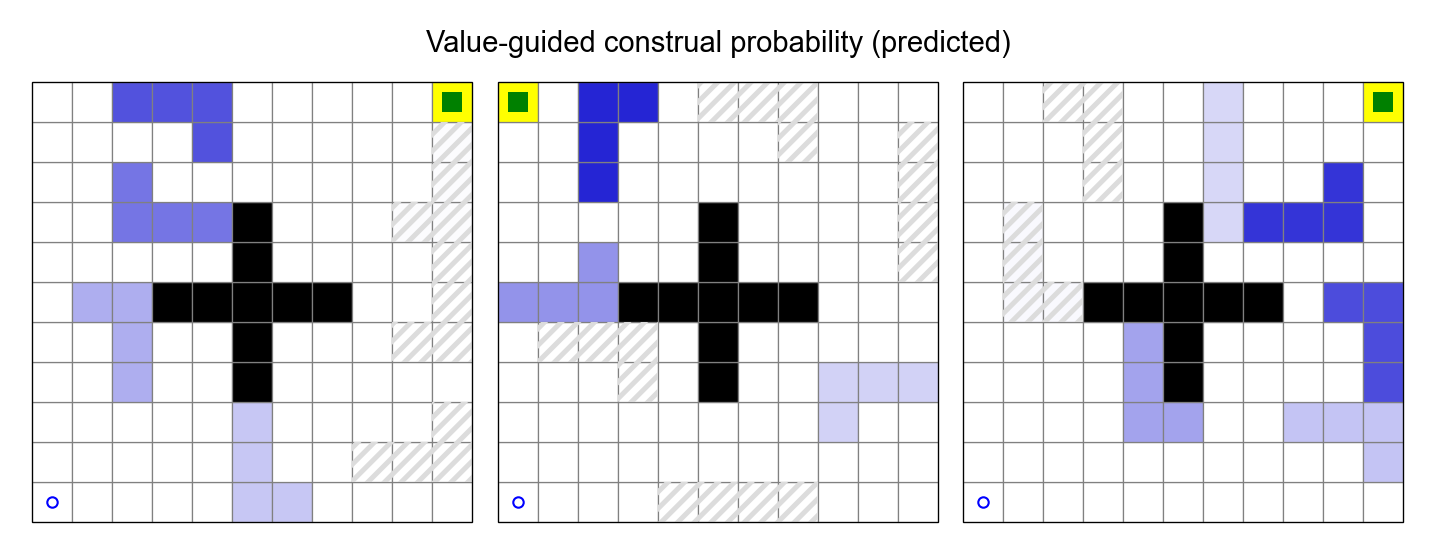

In [18]:
# model predictions
# create figure
matplotlib.rcParams['hatch.linewidth'] = 1.2  # previous svg hatch linewidth

fig_width_mm = 120
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
# grids_to_plot = list(range(12))
grids_to_plot = [2, 3, 11]
to_plot = expmod_means[expmod_means["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(to_plot['grid'].unique())
ncols = 3
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = expmod_means.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_values(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "yellow"},
        obstacle_values=obstacle_values,
        value_range=(0, 1.0),
        grid_lineweight=.30,
        hatch_cutoff=.1
    )
    # ax.set_title(gridname, fontsize=4)
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.85)
suptitle.set_fontsize(7)
# fig.suptitle('model').set_fontsize(2)
plt.tight_layout(pad=.5)
# fig.savefig("results/exp1_3maze_preds_dvgc.pdf")

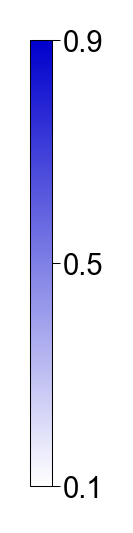

In [19]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib import cm

matplotlib.rcParams['hatch.linewidth'] = 1  # previous svg hatch linewidth

N=256
vmin=.1
vmax=.9
ticks=[.1, .5, .9]

fig_width_mm = 20
fig_height_mm = 50
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, ax = plt.subplots(
    1, 1,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)

vals = np.linspace(0, 1, N)[:,None]
vals = color_mix(vals)
newcmp = ListedColormap(vals)
norm = Normalize(vmin=vmin, vmax=vmax)
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp), ticks=ticks)
cb.ax.tick_params(axis = 'both', which = 'major', width=.25, length=2, pad=.5)
cb.outline.set_linewidth(.25)
cb.minorticks_off()
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("Arial")
    l.set_fontsize(7)
ax.remove()
cb.ax.add_patch(Rectangle((0, 0), 1, .02, fill=False, ec='w', lw=0, hatch='/'*9))
# fig.savefig("results/exp1_colorbar2_dvgc.pdf")

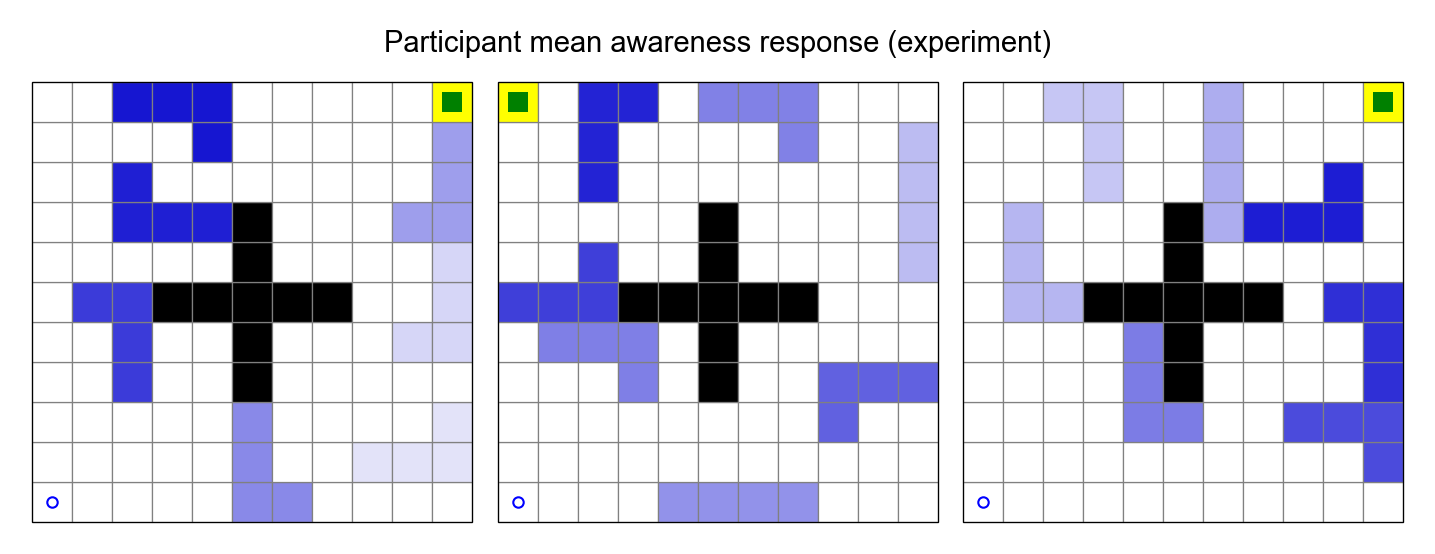

In [20]:
# data
# create figure
fig_width_mm = 120
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
# grids_to_plot = list(range(12))
grids_to_plot = [2, 3, 11]
to_plot = expmod_means[expmod_means["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(to_plot['grid'].unique())
ncols = 3
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'attention_N'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = expmod_means.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_values(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "yellow"},
        obstacle_values=obstacle_values,
        value_range=(.1, .9),
        grid_lineweight=.30
    )
    # ax.set_title(gridname, fontsize=4)
suptitle = plt.suptitle("Participant mean awareness response (experiment)", font="Arial", y=.85)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
# fig.savefig("results/exp1_3maze_data_dvgc.pdf")